# Analysis of Parameter Estimation

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import tellurium as te  
import json
import os
import sys
sys.path.append('../Estimation/')
from estimation import set_model_to_ss

In [56]:
def simulate_model2(model="no", model_path = '../LCT_model/general_LCT_OIE.ant', 
                   infection_pars: dict = {}, name='general', 
                   ss_duration:float=4., pre_t:float=10.0, simulation_end:float=50.0, 
                   bool_med= True, bool_set_pars=False,
                   selections:list=['time', '[R]', '[iE]', '[E]','[M]','[P]', 'oiE', 'Hkt',
                                     'Hb', 'LDH', 'parasitemia', 'RPI', 'J_oiE_death',
                                     'J_P_birth', 'J_P_death',
                                     'k_E_death','rpi_step_func'] 
                                     + [f'[oiE_{i}]' for i in range(1, 7)]):
    """Simulates model for given BH_max value and returns dataframe with results. 
    Includes presimulation for specific time (infection_after)."""
    if type(model)==str:
        model = te.loada(model_path)
   
    if bool_set_pars:
        for p in infection_pars:
            try:
                model.setValue(p, infection_pars[p])    # CAUTION: if you include a volume which is not 1 in the model, species might get fucked up
            except RuntimeError:
                continue
            
    model = set_model_to_ss(model,infection_pars, name)
    
    # ss simulation
    model.M = 0
    model.events_medication_on = False 
    ss_res = model.simulate(-ss_duration-pre_t, -pre_t, 10, selections=selections)
    ss_res_df = pd.DataFrame(ss_res, columns=ss_res.colnames)    

    # infection simulation
    model.M = 1e3

    for p in infection_pars:
         try:
             model.setValue(p, infection_pars[p])    # CAUTION: if you include a volume which is not 1 in the model, species might get fucked up
         except RuntimeError:
             continue
    # ACT addition
    model.events_medication_on = bool_med
    act_res = model.simulate(-pre_t, simulation_end, 501, selections=selections) #int(simulation_end+pre_t)*10
    act_res_df = pd.DataFrame(act_res, columns=act_res.colnames) 

    # combine results
    res_df = pd.concat([ss_res_df, act_res_df], axis=0)    
    return res_df 

### Load all data relevant for analysis

In [57]:
pth_model = te.loada('../LCT_model/general_LCT_OIE.ant')
non_pth_model = te.loada('../LCT_model/general_LCT_OIE.ant')

data = pd.read_csv('../datasets/OIE_data.csv')

# Define the directory containing the files
directory = '../Estimation/pth/'

# Initialize an empty list to store file names
file_list = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    # Check if the path is a file (not a directory)
    if os.path.isfile(filepath):
        # Add the file path to the list
        file_list.append(filepath)
file_list = sorted(file_list)
newest_file_name = file_list[-1].split("/")[-1].split(".")[0]
estimation_run = newest_file_name                          
#estimation_run = '2024_02_13_15_09_1' # k_M_death, t_E_death separate 
#estimation_run = '2024_02_13_16_28_1' # all separate

#estimation_run = "2024_02_07_15_51_1" # hill function estimation
#no hill function estimation, too high J_P_death but better R: "2023_12_20_17_13_1" 
#estimation Hkt_init: "2023_12_18_11_09_1"
#nice curves, estimated k_P_birth: 2023_12_14_14_50_1           
#Best cost function, but new steady state as k_P_birth higher: "2023_12_15_10_44_1"

fit_data_pth = pd.read_csv('../Estimation/pth.csv')
with open(f'../Estimation/pth/{estimation_run}.json', 'r') as f:
  pth_result = json.load(f)

fit_data_non_pth = pd.read_csv('../Estimation/non_pth.csv')
with open(f'../Estimation/non_pth/{estimation_run}.json', 'r') as f:
  non_pth_result = json.load(f)
print(estimation_run)

2024_02_23_14_01_1


In [58]:
species_selct = ['time', '[R]', '[iE]', '[E]', 'oiE', 'Hkt', 'Hb', 'LDH',
                 'parasitemia', 'RPI', 'J_P_aging', 'J_P_death', '[P]',"J_P_birth",
                 'J_oiE_death', 'k_E_death', 'k_P_birth'] + [f'[oiE_{i}]' for i in range(1, 7)]
pth_model.resetToOrigin()
for p in pth_result['update_parameters']:
    pth_model.setValue(p, pth_result['update_parameters'][p])
    
pre_t = pth_result['best_parameters']['pre_t']
pth_res = pth_model.simulate(-pre_t, 100, 200, selections=species_selct)
pth_res_df = pd.DataFrame(pth_res, columns=pth_res.colnames) 

non_pth_model.resetToOrigin()
for p in non_pth_result['update_parameters']:
    non_pth_model.setValue(p, non_pth_result['update_parameters'][p])

pre_t = non_pth_result['best_parameters']['pre_t']
#non_pth_model.events_medication_on = False
non_pth_res = non_pth_model.simulate(-pre_t, 100, 200, selections=species_selct)
non_pth_res_df = pd.DataFrame(non_pth_res, columns=non_pth_res.colnames) 


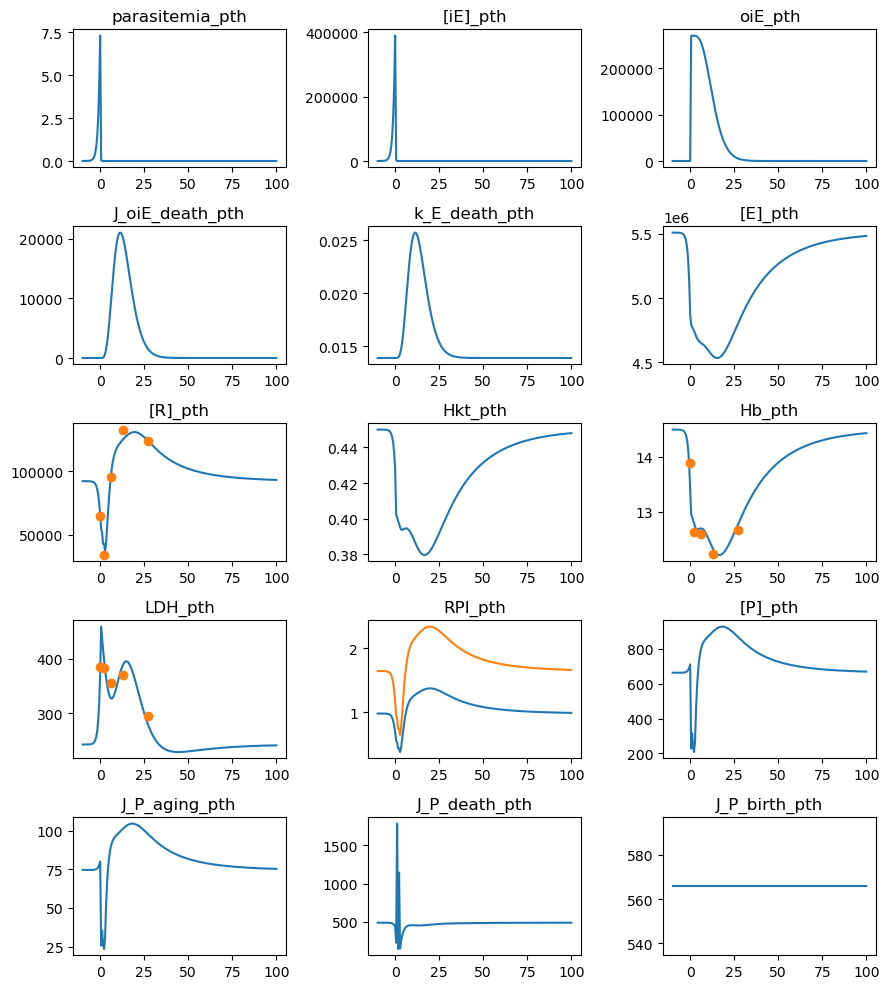

In [59]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[P]', 'J_P_aging', 'J_P_death',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(pth_res_df['time'], pth_res_df[obs], label='no BH')
    ax[row, col].plot(pth_res_df['time'], pth_res_df[obs])

    ax[row, col].set_title(obs+"_pth")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='data')
# maturation time = 1, assumption Hkt does go underneath 0.4, in model   
rpi_calc = (pth_res_df['[R]'] / (pth_res_df['[R]'] + pth_res_df['[E]']+pth_res_df['[iE]'] + pth_res_df['oiE'])) * pth_res_df['Hkt'] / (0.45*0.01)
ax[3, 1].plot(pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()

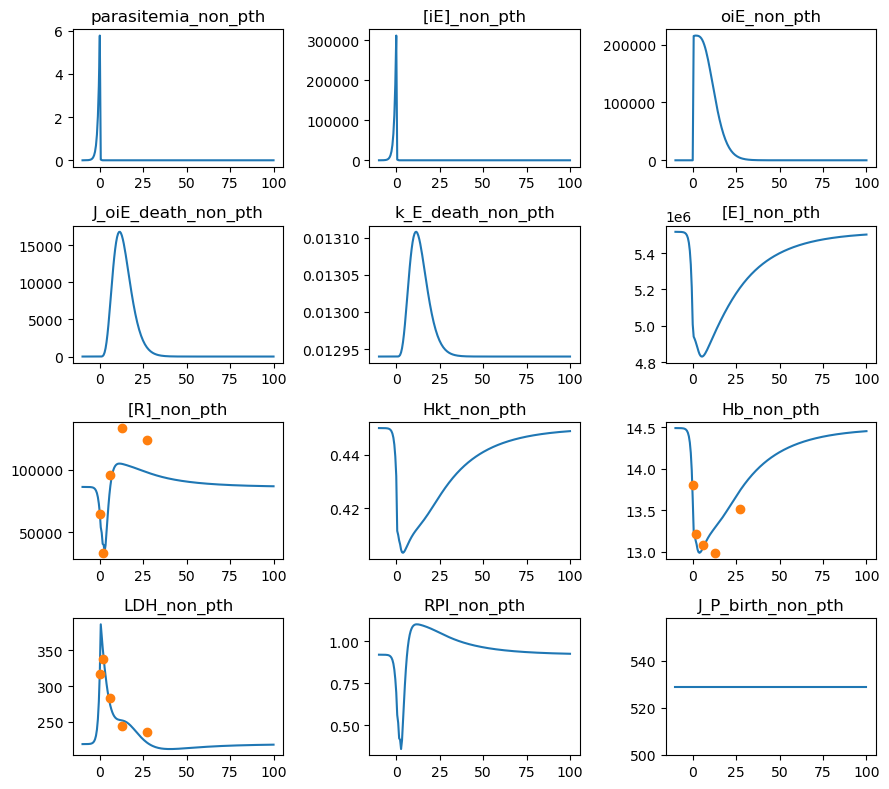

In [60]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death','[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(pth_res_df['time'], pth_res_df[obs], label='no BH')
    ax[row, col].plot(non_pth_res_df['time'], non_pth_res_df[obs])

    ax[row, col].set_title(obs+"_non_pth")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='data')

plt.tight_layout()  
plt.show()


## Immune model

In [61]:
name = 'immune'
pth_model = te.loada(f'../LCT_model/{name}_LCT_OIE.ant')
non_pth_model = te.loada(f'../LCT_model/{name}_LCT_OIE.ant')

data = pd.read_csv('../datasets/OIE_data.csv')

# Define the directory containing the files
directory = f'../Estimation/{name}/pth/'

# Initialize an empty list to store file names
file_list = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    # Check if the path is a file (not a directory)
    if os.path.isfile(filepath):
        # Add the file path to the list
        file_list.append(filepath)
file_list = sorted(file_list)
newest_file_name = file_list[-1].split("/")[-1].split(".")[0]
estimation_run = newest_file_name                          
#estimation_run = '2024_02_13_15_09_1' # k_M_death, t_E_death separate 
#estimation_run = '2024_02_13_16_28_1' # all separate

#estimation_run = "2024_02_07_15_51_1" # hill function estimation
#no hill function estimation, too high J_P_death but better R: "2023_12_20_17_13_1" 
#estimation Hkt_init: "2023_12_18_11_09_1"
#nice curves, estimated k_P_birth: 2023_12_14_14_50_1           
#Best cost function, but new steady state as k_P_birth higher: "2023_12_15_10_44_1"

fit_data_pth = pd.read_csv('../Estimation/pth.csv')
with open(f'../Estimation/{name}/pth/{estimation_run}.json', 'r') as f:
  pth_result = json.load(f)

fit_data_non_pth = pd.read_csv('../Estimation/non_pth.csv')
with open(f'../Estimation/{name}/non_pth/{estimation_run}.json', 'r') as f:
  non_pth_result = json.load(f)
print(estimation_run)

2024_03_02_09_15_1


In [62]:
species_selct = ['time', '[R]', '[iE]', '[E]', 'oiE', 'Hkt', 'Hb', 'LDH','[Ttox]','[Treg]',
                 'parasitemia', 'RPI', 'J_P_aging', 'J_P_death', '[P]',"J_P_birth",
                 'J_oiE_death', 'k_E_death', 'k_P_birth'] + [f'[oiE_{i}]' for i in range(1, 7)]
pth_model.resetToOrigin()
for p in pth_result['update_parameters']:
    try:
        pth_model.setValue(p, pth_result['update_parameters'][p])
    except RuntimeError:
        continue
pre_t = pth_result['best_parameters']['pre_t']
#pth_res = pth_model.simulate(-pre_t, 100, 200, selections=species_selct)
pth_res_df = simulate_model2(pth_model, infection_pars=pth_result['update_parameters'], 
                             name='immune', ss_duration=50, simulation_end=100,
                             selections=species_selct)

non_pth_model.resetToOrigin()
for p in non_pth_result['update_parameters']:
    try:
        non_pth_model.setValue(p, non_pth_result['update_parameters'][p])
    except RuntimeError:
        continue
pre_t = non_pth_result['best_parameters']['pre_t']
#non_pth_model.events_medication_on = False
non_pth_res_df = simulate_model2(non_pth_model, infection_pars=non_pth_result['update_parameters'], 
                                 name='immune', ss_duration=50, simulation_end=100,
                                 selections=species_selct)

/home/nexia/miniconda3/envs/phd/lib/python3.10/site-packages/roadrunner/roadrunner.py:4687: UserWarning:

Simulation requested end time point (-10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. rr.simulate(-14.0, -10.0, 1001)
  * Setting rr.integrator.variable_step_size to 'False'
  * Setting rr.integrator.max_output_rows to a larger number 

/home/nexia/miniconda3/envs/phd/lib/python3.10/site-packages/roadrunner/roadrunner.py:4687: UserWarning:

Simulation requested end time point (-10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. rr.simulate(-14.0, -10.0, 1001)
  * Setting rr.integrator.variable_step_size to 'False'
  * Setting rr.integrator.max_output_rows to a larger number 



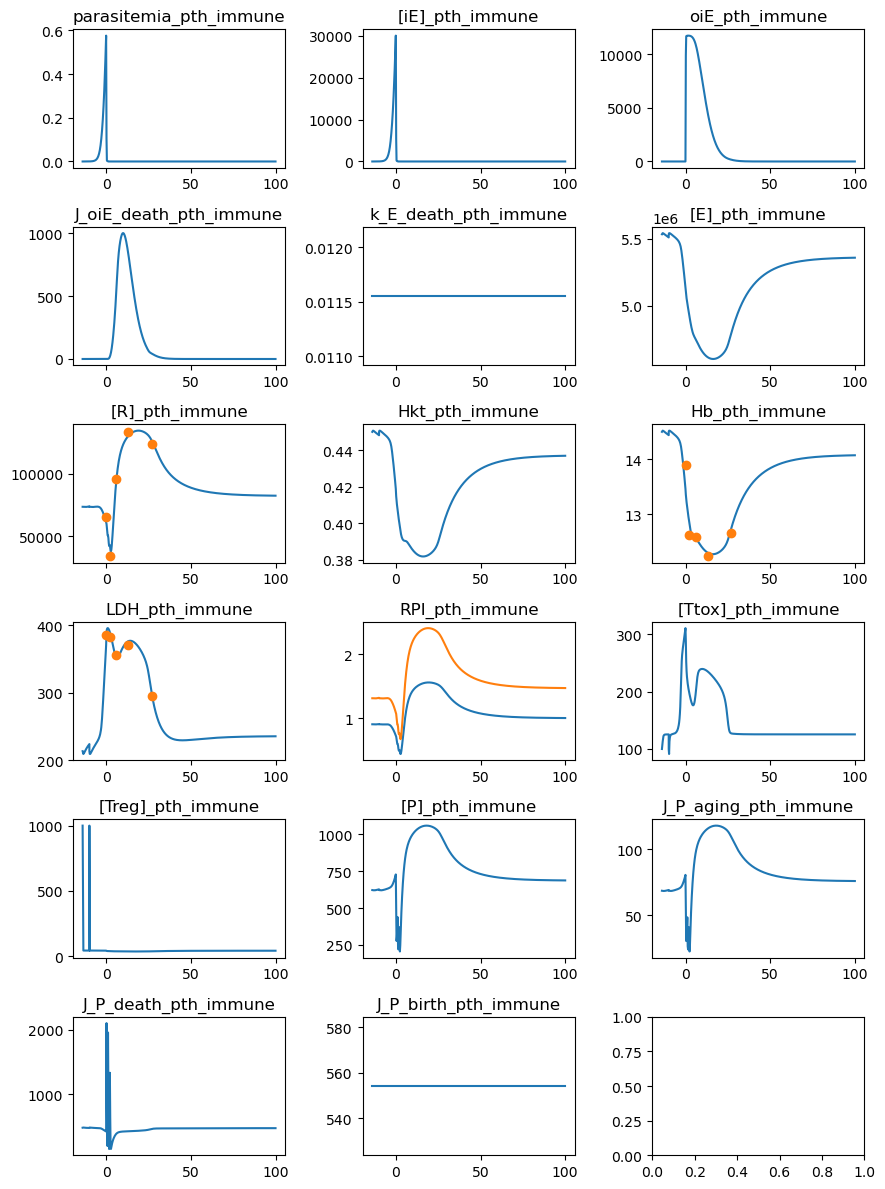

In [63]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[Ttox]','[Treg]','[P]',
               'J_P_aging', 'J_P_death',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(pth_res_df['time'], pth_res_df[obs], label='no BH')
    ax[row, col].plot(pth_res_df['time'], pth_res_df[obs])

    ax[row, col].set_title(obs+f"_pth_{name}")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='data')
# maturation time = 1, assumption Hkt does go underneath 0.4, in model   
rpi_calc = (pth_res_df['[R]'] / (pth_res_df['[R]'] + pth_res_df['[E]']+pth_res_df['[iE]'] + pth_res_df['oiE'])) * pth_res_df['Hkt'] / (0.45*0.01)
ax[3, 1].plot(pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()

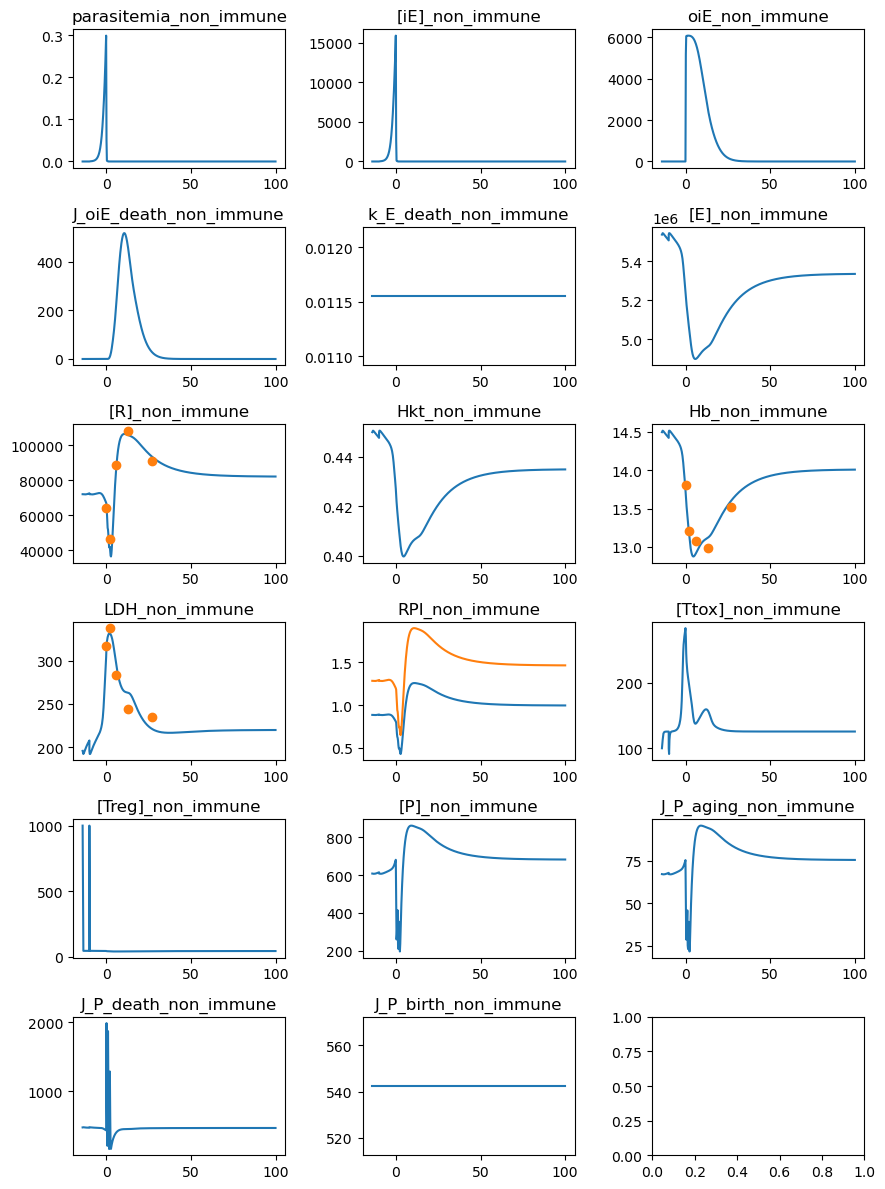

In [64]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[Ttox]','[Treg]','[P]',
               'J_P_aging', 'J_P_death',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(non_pth_res_df['time'], non_pth_res_df[obs], label='no BH')
    ax[row, col].plot(non_pth_res_df['time'], non_pth_res_df[obs])

    ax[row, col].set_title(obs+f"_non_{name}")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['[R]_mean'], 'o', label='data')
# maturation time = 1, assumption Hkt does go underneath 0.4, in model   
rpi_calc = (non_pth_res_df['[R]'] / (non_pth_res_df['[R]'] + non_pth_res_df['[E]']+non_pth_res_df['[iE]'] + non_pth_res_df['oiE'])) * non_pth_res_df['Hkt'] / (0.45*0.01)
ax[3, 1].plot(non_pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()

### Haptoglobin

In [65]:
name = 'Hapto'
pth_model = te.loada(f'../LCT_model/{name}_LCT_OIE.ant')
non_pth_model = te.loada(f'../LCT_model/{name}_LCT_OIE.ant')

data = pd.read_csv('../datasets/OIE_data.csv')

# Define the directory containing the files
directory = f'../Estimation/{name}/pth/'

# Initialize an empty list to store file names
file_list = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    # Check if the path is a file (not a directory)
    if os.path.isfile(filepath):
        # Add the file path to the list
        file_list.append(filepath)
file_list = sorted(file_list)
newest_file_name = file_list[-1].split("/")[-1].split(".")[0]
estimation_run = newest_file_name                          

with open(f'../Estimation/{name}/pth/{estimation_run}.json', 'r') as f:
  pth_result = json.load(f)

with open(f'../Estimation/{name}/non_pth/{estimation_run}.json', 'r') as f:
  non_pth_result = json.load(f)
print(estimation_run)

2024_03_04_10_31_1


In [66]:
species_selct = ['time', '[R]', '[iE]', '[E]', 'oiE', 'Hkt', 'Hb', 'LDH','[fHb]','[HP]',
                 'parasitemia', 'RPI', 'J_P_aging', 'J_P_death', '[P]',"J_P_birth",
                 'J_oiE_death', 'k_E_death', 'k_P_birth'] + [f'[oiE_{i}]' for i in range(1, 7)]
pth_model.resetToOrigin()
for p in pth_result['update_parameters']:
    try:
        pth_model.setValue(p, pth_result['update_parameters'][p])
    except RuntimeError:
        continue
pre_t = pth_result['best_parameters']['pre_t']
#pth_res = pth_model.simulate(-pre_t, 100, 200, selections=species_selct)
pth_res_df = simulate_model2(pth_model, infection_pars=pth_result['update_parameters'], 
                             name='Hapto', simulation_end=100, selections=species_selct)

non_pth_model.resetToOrigin()
for p in non_pth_result['update_parameters']:
    try:
        non_pth_model.setValue(p, non_pth_result['update_parameters'][p])
    except RuntimeError:
        continue
pre_t = non_pth_result['best_parameters']['pre_t']
#non_pth_model.events_medication_on = False
non_pth_res_df = simulate_model2(non_pth_model, infection_pars=non_pth_result['update_parameters'], 
                                 name='Hapto', simulation_end=100, selections=species_selct)

/home/nexia/miniconda3/envs/phd/lib/python3.10/site-packages/roadrunner/roadrunner.py:4687: UserWarning:

Simulation requested end time point (-10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. rr.simulate(-14.0, -10.0, 1001)
  * Setting rr.integrator.variable_step_size to 'False'
  * Setting rr.integrator.max_output_rows to a larger number 

/home/nexia/miniconda3/envs/phd/lib/python3.10/site-packages/roadrunner/roadrunner.py:4687: UserWarning:

Simulation requested end time point (-10.0) not reached, because the maximum number of steps reached.  Possible solutions include:
  * Setting an explicit number of points (i.e. rr.simulate(-14.0, -10.0, 1001)
  * Setting rr.integrator.variable_step_size to 'False'
  * Setting rr.integrator.max_output_rows to a larger number 



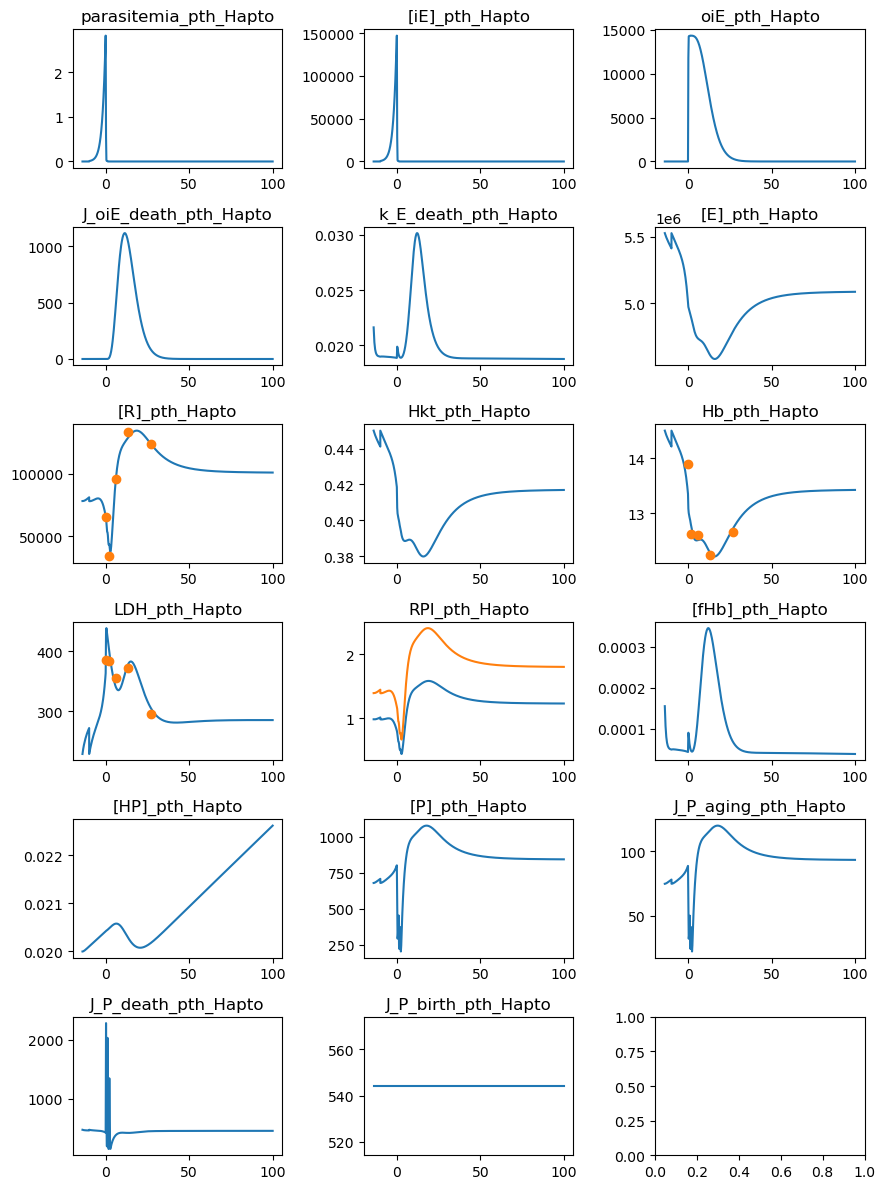

In [67]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[fHb]','[HP]','[P]',
               'J_P_aging', 'J_P_death',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(pth_res_df['time'], pth_res_df[obs], label='no BH')
    ax[row, col].plot(pth_res_df['time'], pth_res_df[obs])

    ax[row, col].set_title(obs+f"_pth_{name}")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_pth['Time'], fit_data_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_pth['Time'], fit_data_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_pth['Time'], fit_data_pth['[R]_mean'], 'o', label='data')
# maturation time = 1, assumption Hkt does go underneath 0.4, in model   
rpi_calc = (pth_res_df['[R]'] / (pth_res_df['[R]'] + pth_res_df['[E]']+pth_res_df['[iE]'] + pth_res_df['oiE'])) * pth_res_df['Hkt'] / (0.45*0.01)
ax[3, 1].plot(pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()

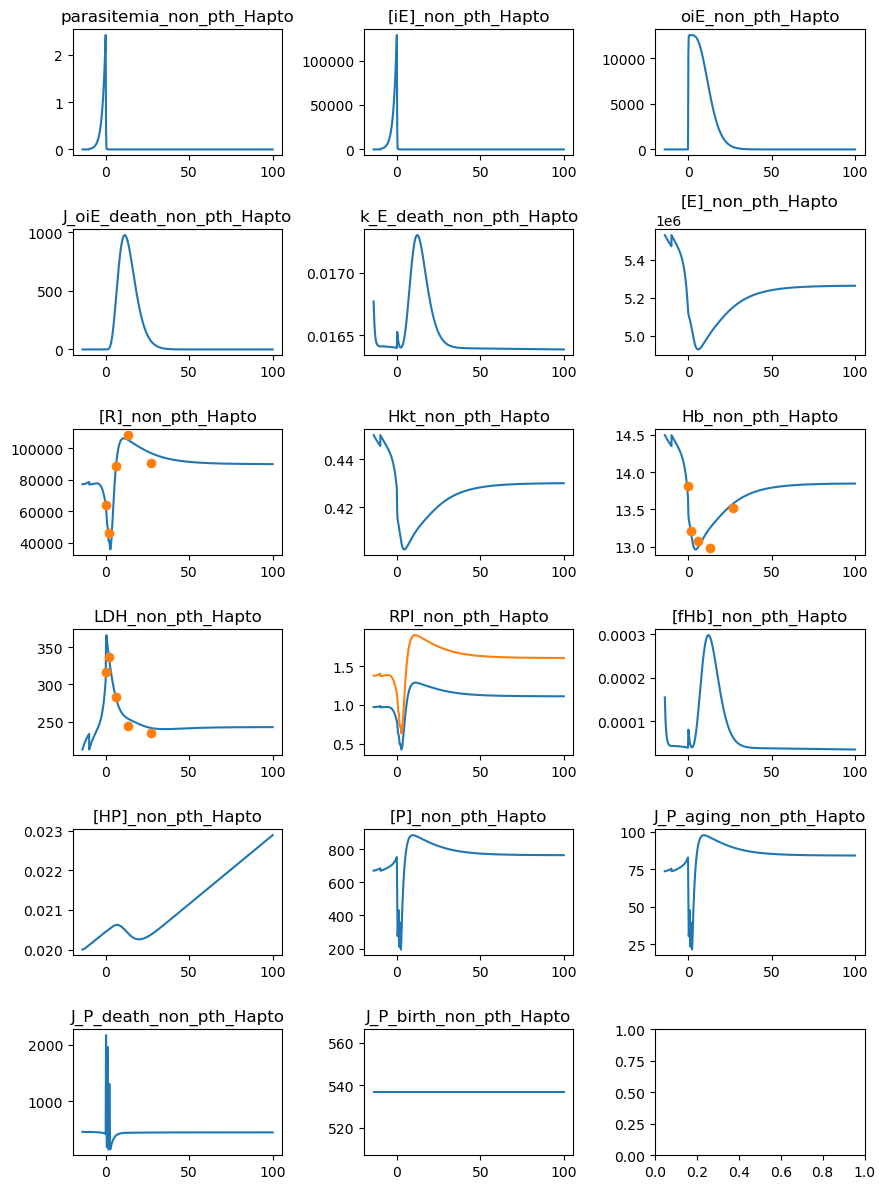

In [68]:
## plot results
observables = ['parasitemia', '[iE]', 'oiE', 'J_oiE_death', 'k_E_death',
               '[E]', '[R]', 'Hkt' ,'Hb', 'LDH','RPI','[fHb]','[HP]','[P]',
               'J_P_aging', 'J_P_death',"J_P_birth"]

n_cols = 3
n_rows = int(np.ceil(len(observables)/n_cols))  

fig, ax = plt.subplots(n_rows, n_cols, squeeze=True, figsize=(n_cols*3, n_rows*2))

for i, obs in enumerate(observables):
    row = i//n_cols
    col = i%n_cols
    #ax[row, col].plot(non_pth_res_df['time'], non_pth_res_df[obs], label='no BH')
    ax[row, col].plot(non_pth_res_df['time'], non_pth_res_df[obs])

    ax[row, col].set_title(obs+f"_non_pth_{name}")
    #ax[row, col].legend()
ax[3,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['LDH_mean'], 'o', label='data')
ax[2,2].plot(fit_data_non_pth['Time'], fit_data_non_pth['Hb_mean'], 'o', label='data')
ax[2,0].plot(fit_data_non_pth['Time'], fit_data_non_pth['[R]_mean'], 'o', label='data')
# maturation time = 1, assumption Hkt does go underneath 0.4, in model   
rpi_calc = (non_pth_res_df['[R]'] / (non_pth_res_df['[R]'] + non_pth_res_df['[E]']+non_pth_res_df['[iE]'] + non_pth_res_df['oiE'])) * non_pth_res_df['Hkt'] / (0.45*0.01)
ax[3, 1].plot(non_pth_res_df['time'], rpi_calc)

plt.tight_layout()  
plt.show()